In [1]:
#from GetSatellitesGSM import get_artemis_gsm
from scipy.stats import linregress, pearsonr
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
import os
# Plots all three events with the 4-hour prerun interval. It makes this interval dashed.

In [2]:
def find_max_value_and_index(values):
    if all(c < 0 for c in values[1:]):
        return max(values[1:], key=abs), values.index(max(values[1:], key=abs))
    else:
        return max(values[1:]), values.index(max(values[1:]))

def correlate_whole_day(artemis, omni, key='BZ_GSM'):
    data_rows = []  # Storage array to hold data
    offset_rows = []    # Storage array to hold time shifts

    artemis_start = artemis.loc[artemis['Time'] == omni['Time'].iloc[0]].index[0]   # Start the Artemis slice at the timestamp equal to the first timestamp of the OMNI slice
    artemis_stop = artemis.loc[artemis['Time'] == omni['Time'].iloc[-1]].index[0]   # Stop the Artemis slice at the last timestamp of the OMNI slice

    metric_names = ['Pearson']    # Names for the things we are solving for
    metric_stores = {name: [] for name in metric_names}     # Storage dictionary for metrics, create a key with the metric name and blank array as the value
    target_stores = {name + ' Target': [] for name in metric_names}     # Storage array for the target values we are trying to find (in this case, largest CC)

    for i in range(31):     # Sliding the Artemis array with respect to the fixed OMNI array 30 minutes
        o_slice = omni[key]    # Get the 60-minute OMNI chunk (i.e. :00 to :59)
        a_slice = artemis[key][artemis_start - i:artemis_stop - i+1] # Get the 60-minute Artemis chunk (i.e. :00-:59, :01-:00, etc.)

        correlation, _ = pearsonr(o_slice, a_slice)    # Get a Pearson correlation for this interval

        for count, (metric, store) in enumerate(metric_stores.items()):
            store.append(correlation)

    pearson_max_value, pearson_max_index = find_max_value_and_index(metric_stores['Pearson'])
    target_stores['Pearson Target'] = [pearson_max_value, pearson_max_index]


    data_rows.append(np.concatenate(([omni['Time'].iloc[0]], [omni['Time'].iloc[-1]], *[store[0] for name, store in target_stores.items()], *[store[1] for name, store in target_stores.items()]), axis=None))


    values = pd.DataFrame(data_rows, columns=['Start', 'Stop', 'Pearson', 'Shift']) #Add the average, std_dev, etc to this???

    return (target_stores['Pearson Target'][0], target_stores['Pearson Target'][1])

In [ ]:
dates = ['2016-05-06 12:00:00', '2022-10-24 00:00:00']
keys = ['BX_GSM', 'BY_GSM', 'BZ_GSM', 'VX', 'VY', 'VZ', 'N', 'T']
names = [r'$B_x$ GSM (nT)', r'$B_y$ GSM (nT)', r'$B_z$ GSM (nT)', r'$V_x$ GSM (km/s)', r'$V_y$ GSM (km/s)', r'$V_z$ GSM (km/s)', r'Proton Density (n/cc)', 'Temperature (K)']

for d in dates:
    start_time = pd.to_datetime(d, format='%Y-%m-%d %H:%M:%S')-dt.timedelta(days=1)-dt.timedelta(minutes=30)
    stop_time = pd.to_datetime(d, format='%Y-%m-%d %H:%M:%S')+dt.timedelta(days=1)-dt.timedelta(seconds=1)
    print(start_time, stop_time)

    omni_data, artemis_data = get_artemis_gsm(start_time, stop_time)
    artemis_data.to_csv(f'artemis_{(start_time+dt.timedelta(days=1, minutes=30)).strftime("%Y-%m-%d_%H-%M")}.csv')
    omni_data.to_csv(f'omni_{(start_time+dt.timedelta(days=1, minutes=30)).strftime("%Y-%m-%d_%H-%M")}.csv')

In [ ]:
dates = ['2016-05-06_12-00', '2022-10-24_00-00']
shifts = [11, 6]

for d in dates:
    artemis_data = pd.read_csv(f'artemis_{d}.csv', delimiter=',', header=0)
    omni_data = pd.read_csv(f'omni_{d}.csv', delimiter=',', header=0)

    artemis_data['Time'] = pd.to_datetime(artemis_data['Time'], format='%Y-%m-%d %H:%M:%S')
    omni_data['Time'] = pd.to_datetime(omni_data['Time'], format='%Y-%m-%d %H:%M:%S')

    x_start = artemis_data['Time'].iloc[0]+dt.timedelta(days=1, minutes=30)
    x_end = artemis_data['Time'].iloc[-1]

    artemis_truncated = artemis_data[(artemis_data['Time'] >= x_start) & (artemis_data['Time'] <= x_end)].drop(columns=['Unnamed: 0']).reset_index(drop=True)
    omni_truncated = omni_data[(omni_data['Time'] >= x_start) & (omni_data['Time'] <= x_end)].drop(columns=['Unnamed: 0']).reset_index(drop=True)

    artemis_truncated_for_correlate = artemis_data[(artemis_data['Time'] >= x_start-dt.timedelta(minutes=30)) & (artemis_data['Time'] <= x_end)].drop(columns=['Unnamed: 0']).reset_index(drop=True)
    shift = correlate_whole_day(artemis_truncated_for_correlate, omni_truncated)

#--- Unshifted Event -----------------------------------------------------------------------------------
    fig, ax = plt.subplots(len(keys), 1, figsize=(12, 2*len(keys)), sharex=True)

    for i, (k, n) in enumerate(zip(keys, names)):
        ax[i].plot(artemis_truncated['Time'], artemis_truncated[k], label='Artemis')
        ax[i].plot(omni_truncated['Time'], omni_truncated[k], label='Omni')
        ax[i].set_xlim([x_start, x_end])
        ax[i].set_ylabel(n)
        ax[i].grid(visible=True, which='both', axis='both')

    ax[-1].xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[-1].xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    ax[-1].set_xlabel('Time UTC')

    ax[0].set_title(f'Event on {x_start.strftime("%Y-%m-%d")}')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig(f'{x_start.strftime("%Y-%m-%d")}-unshifted.png', dpi=300)
    plt.show()

#--- Full Unshifted Event -----------------------------------------------------------------------------------
    fig, ax = plt.subplots(len(keys), 1, figsize=(12, 2*len(keys)), sharex=True)
    for i, (k, n) in enumerate(zip(keys, names)):
        ax[i].plot(artemis_data['Time'], artemis_data[k], label='Artemis')
        ax[i].plot(omni_data['Time'], omni_data[k], label='Omni')
        ax[i].set_xlim([omni_data['Time'].iloc[0], omni_data['Time'].iloc[-1]])
        ax[i].set_ylabel(n)
        ax[i].grid(visible=True, which='both', axis='both')

    ax[-1].xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[-1].xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    ax[-1].set_xlabel('Time UTC')

    ax[0].set_title(f'Event on {x_start.strftime("%Y-%m-%d")} (including pre-run interval)')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig(f'{x_start.strftime("%Y-%m-%d")}-unshifted-fullevent.png', dpi=300)
    plt.show()
#--- Shifted Event -----------------------------------------------------------------------------------
    artemis_shifted_start= artemis_data.loc[artemis_data['Time'] == x_start].index[0]
    artemis_shifted_stop = artemis_data.loc[artemis_data['Time'] == x_end].index[0]

    #omni_shifted_start = omni_data.loc[omni_data['Time'] == x_start].index[0]
    #omni_shifted_stop = omni_data.loc[omni_data['Time'] == x_end].index[0]

    artemis_truncated_shift = artemis_data[artemis_shifted_start-shift[1]:artemis_shifted_stop-shift[1]+1].reset_index(drop=True)
    #omni_truncated_shift = omni_data[omni_shifted_start-s:omni_shifted_stop-s].reset_index(drop=True)

    fig, ax = plt.subplots(len(keys), 1, figsize=(12, 2*len(keys)), sharex=True)

    for i, (k, n) in enumerate(zip(keys, names)):
        ax[i].plot(artemis_truncated['Time'], artemis_truncated_shift[k], label='Artemis')
        ax[i].plot(omni_truncated['Time'], omni_truncated[k], label='Omni')
        ax[i].set_xlim([x_start, x_end])
        ax[i].set_ylabel(n)
        ax[i].grid(visible=True, which='both', axis='both')

    ax[-1].xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[-1].xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    ax[-1].set_xlabel('Time UTC')

    ax[0].set_title(f'Event on {x_start.strftime("%Y-%m-%d")} Shifted')
    ax[0].text(0.8, 1.05, f'Shift = {round(shift[1], 3)} min', transform=ax[0].transAxes, ha='left')
    ax[0].text(0.92, 1.05, f'CC = {round(shift[0], 3)}', transform=ax[0].transAxes, ha='left')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig(f'{x_start.strftime("%Y-%m-%d")}-shifted.png', dpi=300)
    plt.show()

In [ ]:
dates = ['2016-05-06 12:00:00', '2022-10-24 00:00:00']
keys = ['BX_GSM', 'BY_GSM', 'BZ_GSM', 'VX', 'VY', 'VZ', 'N', 'T']
names = [r'$B_x$ GSM (nT)', r'$B_y$ GSM (nT)', r'$B_z$ GSM (nT)', r'$V_x$ GSM (km/s)', r'$V_y$ GSM (km/s)', r'$V_z$ GSM (km/s)', r'Proton Density (n/cc)', 'Temperature (K)']

dates = ['2016-05-06_12-00', '2022-10-24_00-00']
shifts = [11, 6]
ccs = [0.823, 0.585]

for s, d in enumerate(dates):
    artemis_data = pd.read_csv(f'artemis_{d}.csv', delimiter=',', header=0)
    omni_data = pd.read_csv(f'omni_{d}.csv', delimiter=',', header=0)

    artemis_data['Time'] = pd.to_datetime(artemis_data['Time'], format='%Y-%m-%d %H:%M:%S')
    omni_data['Time'] = pd.to_datetime(omni_data['Time'], format='%Y-%m-%d %H:%M:%S')

    if s == 0:
        td = 3
    else:
        td = 0

    x_start = artemis_data['Time'].iloc[0]+dt.timedelta(days=1, minutes=30)-dt.timedelta(hours=4)-dt.timedelta(minutes=td)
    x_end = artemis_data['Time'].iloc[-1]

    omni_truncated = omni_data[(omni_data['Time'] >= x_start) & (omni_data['Time'] <= x_end)].drop(columns=['Unnamed: 0']).reset_index(drop=True)

    artemis_shifted_start = artemis_data.loc[artemis_data['Time'] == x_start].index[0]
    artemis_shifted_stop = artemis_data.loc[artemis_data['Time'] == x_end].index[0]

    artemis_truncated_shift = artemis_data[artemis_shifted_start-shifts[s]:artemis_shifted_stop-shifts[s]+1].drop(columns=['Unnamed: 0']).reset_index(drop=True)
    artemis_truncated_shift['Time'] = omni_truncated['Time']


    fig, ax = plt.subplots(len(keys), 1, figsize=(12, 2*len(keys)), sharex=True)
    for i, (k, n) in enumerate(zip(keys, names)):
        ax[i].plot(artemis_truncated_shift['Time'], artemis_truncated_shift[k], label='Artemis')
        ax[i].plot(omni_truncated['Time'], omni_truncated[k], label='Omni')
        ax[i].set_xlim([omni_truncated['Time'].iloc[0], omni_truncated['Time'].iloc[-1]])
        ax[i].set_ylabel(n)
        ax[i].grid(visible=True, which='both', axis='both')
        ax[i].axvline(x=x_start+dt.timedelta(hours=4), c='red', linestyle='dashed')


    ax[-1].xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[-1].xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    ax[-1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[-1].set_xlabel('Time UTC')

    ax[0].set_title(f'Event on {x_start.strftime("%Y-%m-%d")} (Including 4-hour pre-run interval)')
    ax[0].text(0.8, 1.05, f'Shift = {round(shifts[s], 3)} min', transform=ax[0].transAxes, ha='left')
    ax[0].text(0.92, 1.05, f'CC = {round(ccs[s], 3)}', transform=ax[0].transAxes, ha='left')


    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig(f'simulation_inputs/{x_start.strftime("%Y-%m-%d")}-shifted.png', dpi=300)

    dfs = {'Artemis' : artemis_truncated_shift.drop(columns=['XPOS', 'XSSE', 'YSSE']), 'Omni' : omni_truncated.drop(columns=['Xpos'])}
    for var_name, df in dfs.items():
        df['Year'] = df['Time'].dt.year
        df['Month'] = df['Time'].dt.month
        df['Day'] = df['Time'].dt.day
        df['Hour'] = df['Time'].dt.hour
        df['Minute'] = df['Time'].dt.minute
        df['Second'] = df['Time'].dt.second

        df = df.drop(columns=['Time'])

        columns_order = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second'] + [col for col in df.columns if col not in ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Time']]
        df = df[columns_order]

        df.to_csv(f'simulation_inputs/{var_name}_{x_start.strftime("%Y-%m-%d")}.csv', header=False, index=False)

In [ ]:
dates = ['2012-11-13 00:00:00']
keys = ['BX_GSM', 'BY_GSM', 'BZ_GSM', 'VX', 'VY', 'VZ', 'N', 'T']
names = [r'$B_x$ GSM (nT)', r'$B_y$ GSM (nT)', r'$B_z$ GSM (nT)', r'$V_x$ GSM (km/s)', r'$V_y$ GSM (km/s)', r'$V_z$ GSM (km/s)', r'Proton Density (n/cc)', 'Temperature (K)']

for d in dates:
    start_time = pd.to_datetime(d, format='%Y-%m-%d %H:%M:%S')-dt.timedelta(days=1)-dt.timedelta(minutes=30)
    stop_time = pd.to_datetime(d, format='%Y-%m-%d %H:%M:%S')+dt.timedelta(days=1)-dt.timedelta(seconds=1)
    print(start_time, stop_time)

    omni_data, artemis_data = get_artemis_gsm(start_time, stop_time)
    artemis_data.to_csv(f'artemis_{(start_time+dt.timedelta(days=1, minutes=30)).strftime("%Y-%m-%d_%H-%M")}.csv')
    omni_data.to_csv(f'omni_{(start_time+dt.timedelta(days=1, minutes=30)).strftime("%Y-%m-%d_%H-%M")}.csv')

In [4]:
event_dates = ['2012-11-13', '2016-05-07', '2022-10-24']
file_dates = ['2012-11-13_00-00', '2016-05-06_12-00', '2022-10-24_00-00']

for s, d in enumerate(file_dates):
    artemis_data = pd.read_csv(f'processed solar wind/artemis_{file_dates[s]}.csv', delimiter=',', header=0, index_col=0)
    artemis_data['Time'] = pd.to_datetime(artemis_data['Time'])
    omni_data = pd.read_csv(f'processed solar wind/omni_{file_dates[s]}.csv', delimiter=',', header=0, index_col=0)
    omni_data['Time'] = pd.to_datetime(omni_data['Time'])

    print(omni_data[omni_data['Time'] == dt.datetime.strptime(file_dates[s], '%Y-%m-%d_%H-%M')].index[0])

1439
1437
1440


In [11]:
event_dates = ['2012-11-13', '2016-05-07', '2022-10-24']
file_dates = ['2012-11-13_00-00', '2016-05-06_12-00', '2022-10-24_00-00']

for s, d in enumerate(file_dates):
    artemis_data = pd.read_csv(f'processed solar wind/artemis_{file_dates[s]}.csv', delimiter=',', header=0, index_col=0)
    artemis_data['Time'] = pd.to_datetime(artemis_data['Time'])
    omni_data = pd.read_csv(f'processed solar wind/omni_{file_dates[s]}.csv', delimiter=',', header=0, index_col=0)
    omni_data['Time'] = pd.to_datetime(omni_data['Time'])

    # Define the event start time and data after the prerun
    event_start_index = omni_data[omni_data['Time'] == dt.datetime.strptime(file_dates[s], '%Y-%m-%d_%H-%M')].index[0]

    omni_before = omni_data[0:omni_data[omni_data['Time'] == dt.datetime.strptime(file_dates[s], '%Y-%m-%d_%H-%M')].index[0]]
    omni_after = omni_data[omni_data[omni_data['Time'] == dt.datetime.strptime(file_dates[s], '%Y-%m-%d_%H-%M')].index[0]:]

    shift = correlate_whole_day(artemis_data, omni_after, key='BY_GSM')
    print(file_dates[s])
    print(shift)

2012-11-13_00-00
(0.9826739678864587, 8)
2016-05-06_12-00
(0.8628097069053469, 11)
2022-10-24_00-00
(0.744280168514203, 10)


2012-11-13 min: -20.57, max: 23.47
2012-11-13 min: -20.57, max: 23.47
2016-05-06 min: -10.51, max: 8.01
2016-05-06 min: -10.51, max: 8.01
2022-10-24 min: -7.63, max: 8.35
2022-10-24 min: -7.63, max: 8.35


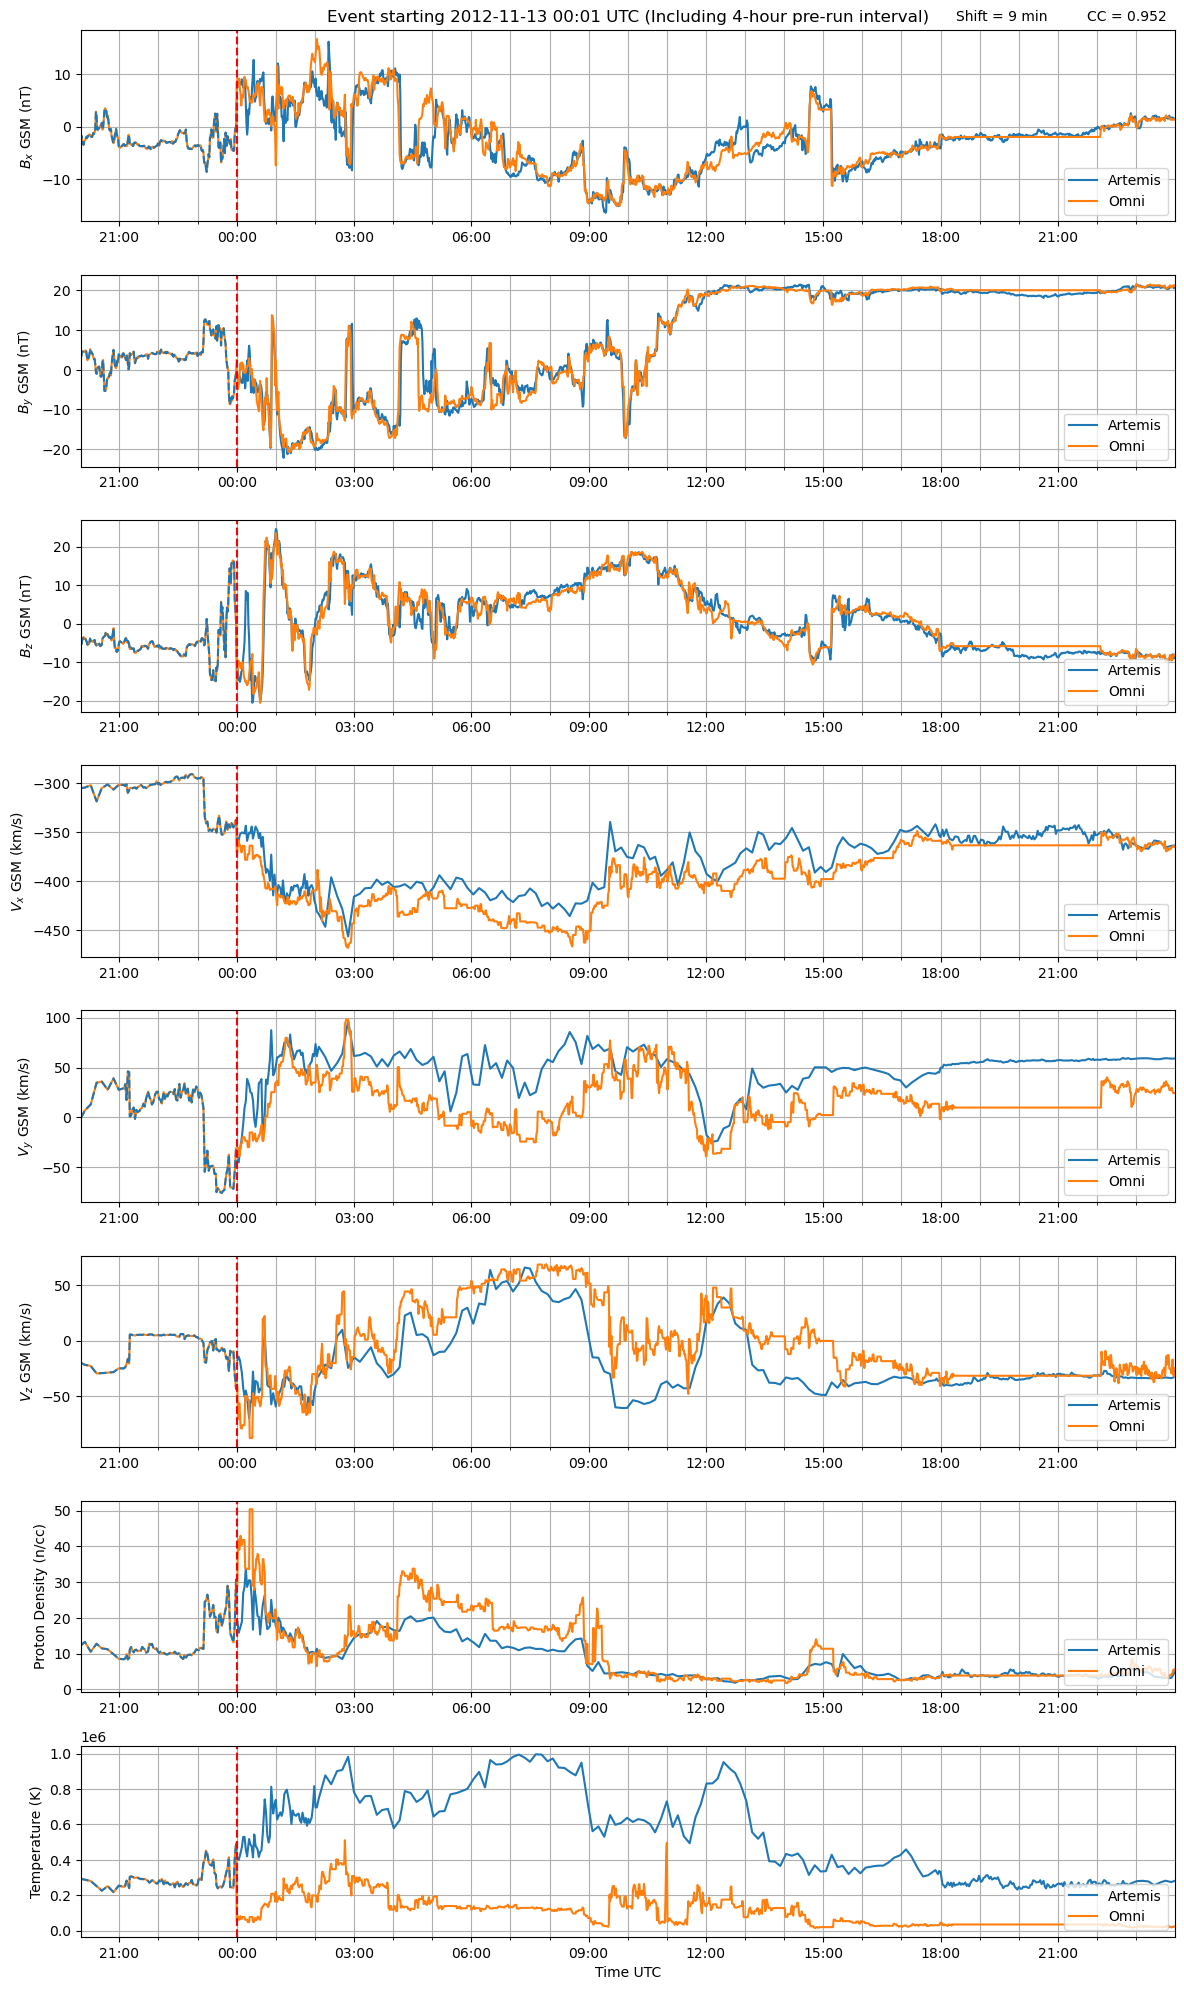

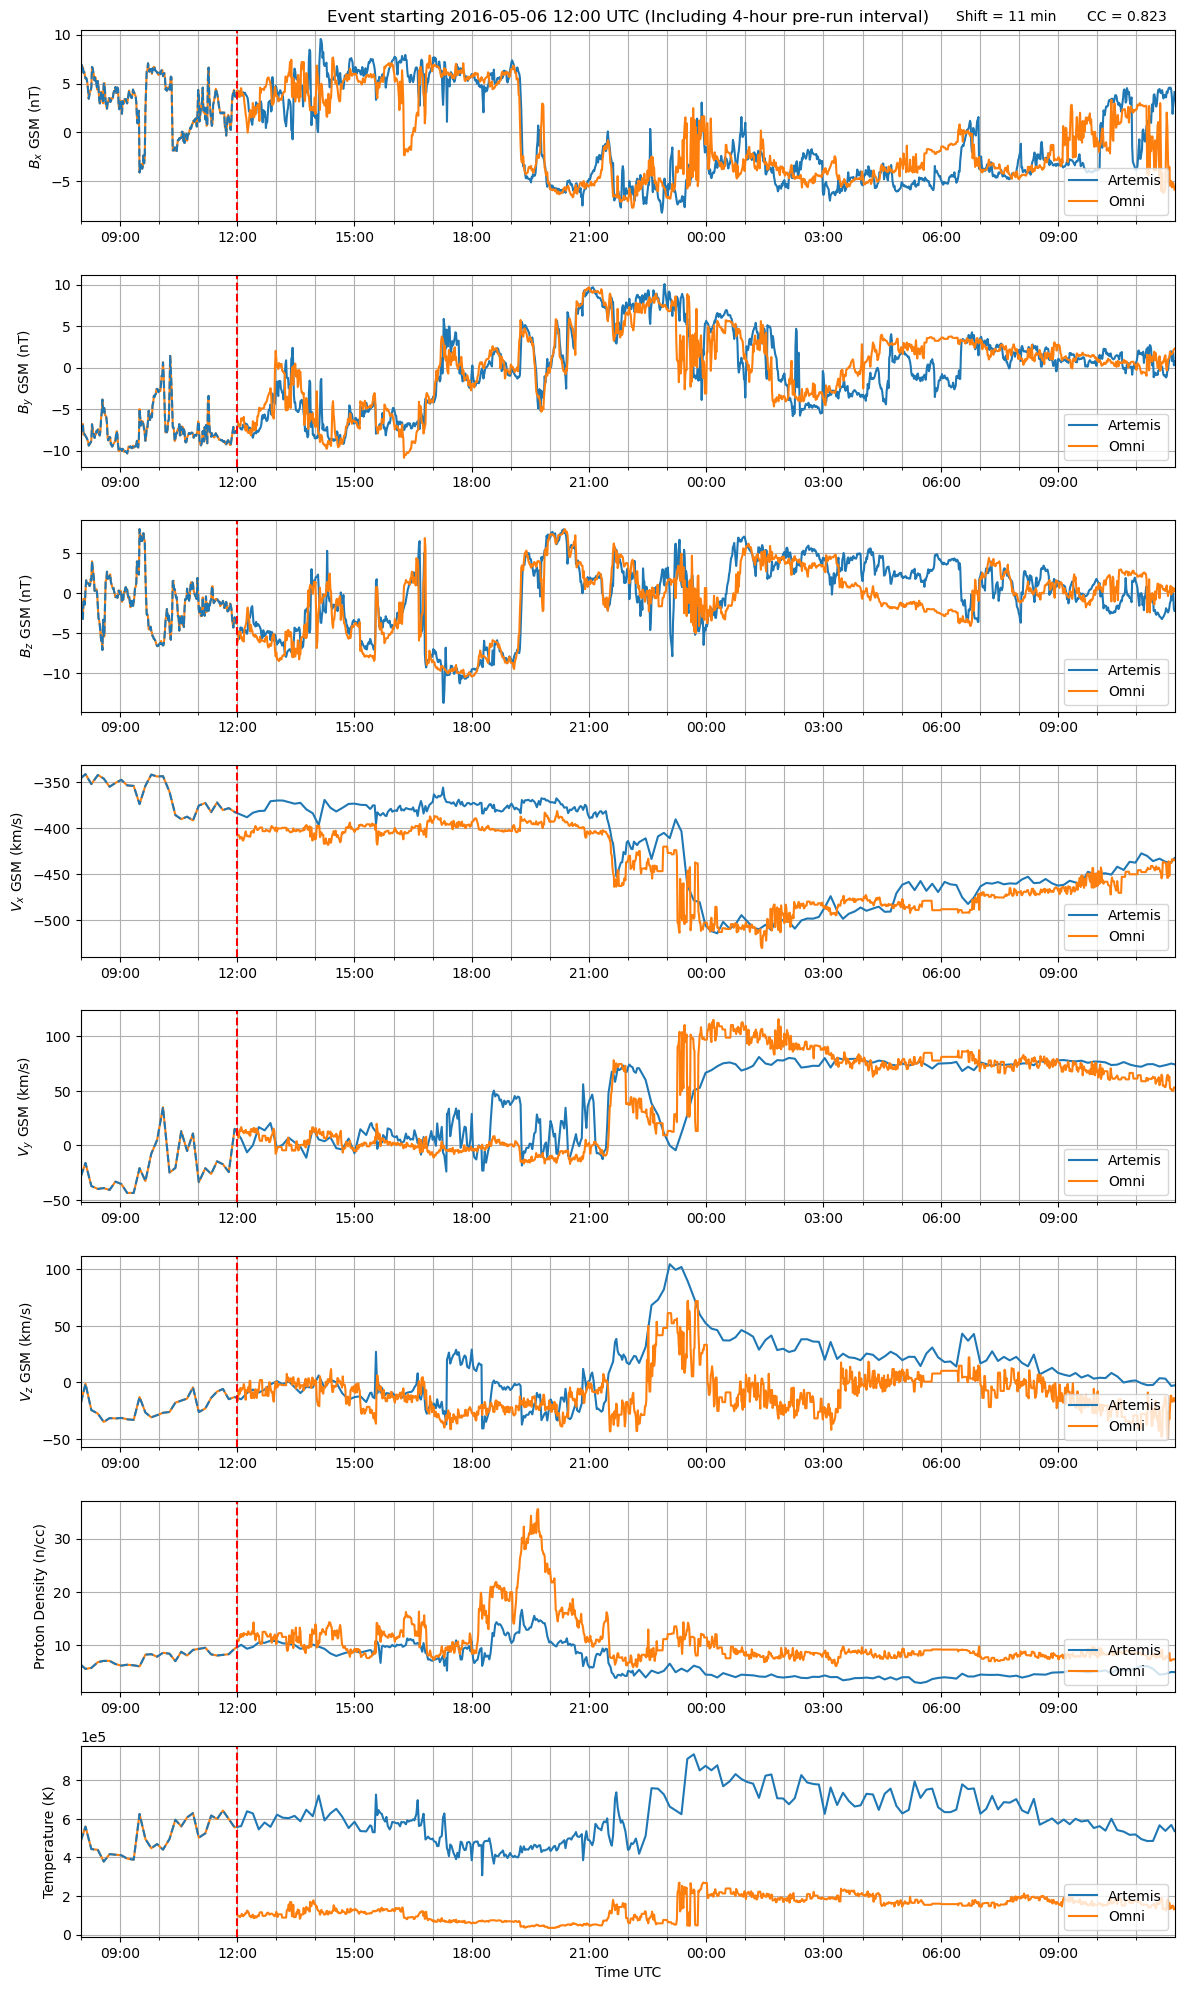

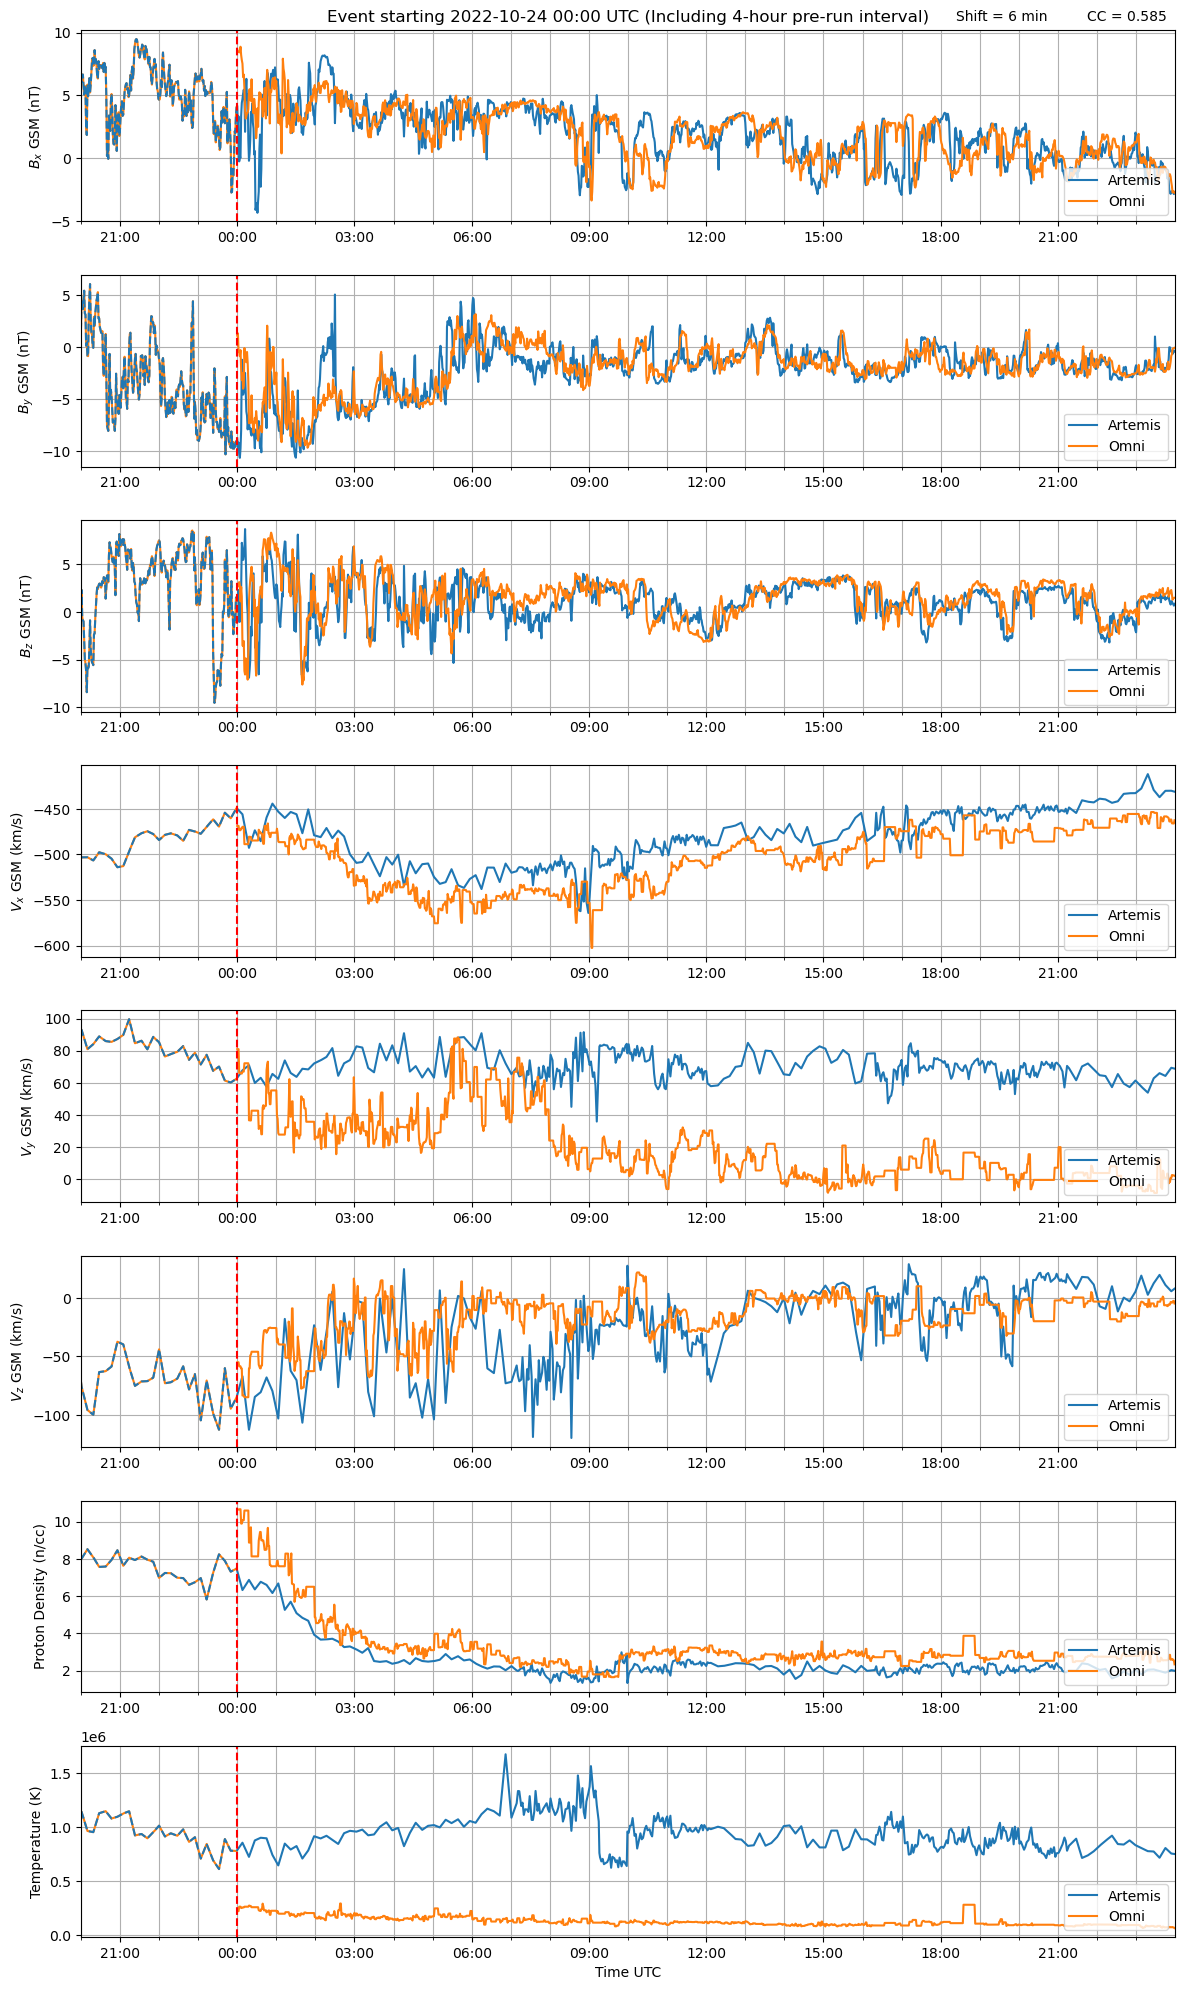

In [24]:
# Plots all three events with the 4-hour prerun interval. It makes this interval dashed.

keys = [6, 7, 8, 9, 10, 11, 12, 13]
names = [r'$B_x$ GSM (nT)', r'$B_y$ GSM (nT)', r'$B_z$ GSM (nT)', r'$V_x$ GSM (km/s)', r'$V_y$ GSM (km/s)', r'$V_z$ GSM (km/s)', r'Proton Density (n/cc)', 'Temperature (K)']

keys2 = []
names2 = []
event_dates = ['2012-11-13', '2016-05-07', '2022-10-24']
file_dates = ['2012-11-12', '2016-05-06', '2022-10-23']

shifts = [9, 11, 6]
ccs = [0.952, 0.823, 0.585]

for s, d in enumerate(event_dates):
    artemis_data = pd.read_csv(f'../simulation_inputs/{d}/Artemis_{file_dates[s]}.csv', delimiter=',', header=None)
    omni_data = pd.read_csv(f'../simulation_inputs/{d}/Omni_{file_dates[s]}_prerun.csv', delimiter=',', header=None)

    for df in [artemis_data, omni_data]:
        datetime_columns = df.iloc[:, :6]
        df['timestamp'] = pd.to_datetime({
            'year': datetime_columns.iloc[:, 0],
            'month': datetime_columns.iloc[:, 1],
            'day': datetime_columns.iloc[:, 2],
            'hour': datetime_columns.iloc[:, 3],
            'minute': datetime_columns.iloc[:, 4],
            'second': datetime_columns.iloc[:, 5]})

    # Define the event start time
    event_start_time = omni_data['timestamp'].iloc[0] + dt.timedelta(hours=4)

    fig, ax = plt.subplots(len(keys), 1, figsize=(12, 2.5*len(keys)), sharex=True)
    for i, (k, n) in enumerate(zip(keys, names)):
        # Split data into segments based on the start time
        artemis_before = artemis_data[artemis_data['timestamp'] < event_start_time]
        artemis_after = artemis_data[artemis_data['timestamp'] >= event_start_time]
        omni_before = omni_data[omni_data['timestamp'] < event_start_time]
        omni_after = omni_data[omni_data['timestamp'] >= event_start_time]

        # Plot segmented lines
        ax[i].plot(omni_before['timestamp'], omni_before[k], color='C1')    # Plot OMNI data before the dashed line
        ax[i].plot(artemis_before['timestamp'], artemis_before[k], color='C0', linestyle='dashed')  # Plot ARTEMIS data before the dashed line

        ax[i].plot(artemis_after['timestamp'], artemis_after[k], label='Artemis', color='C0')   # Plot ARTEMIS data after the dashed line
        ax[i].plot(omni_after['timestamp'], omni_after[k], label='Omni', color='C1')    # Plot OMNI data after the dashed line

        ax[i].set_ylabel(n)

        ax[i].grid(visible=True, which='both', axis='both')
        ax[i].axvline(x=event_start_time, c='red', linestyle='dashed')
        ax[i].tick_params(labelbottom=True)
        ax[i].legend(loc='lower right')

    first_timestamp = omni_data['timestamp'].iloc[0]
    first_hour = first_timestamp.hour
    first_major_tick_hour = (first_hour // 3) * 3  # Nearest hour divisible by 3

    major_ticks = pd.date_range(start=omni_data['timestamp'].iloc[0].replace(hour=first_major_tick_hour, minute=0, second=0), end=omni_data['timestamp'].iloc[-1], freq='3H')

    ax[-1].xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Major ticks every 3 hours
    ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 12-hour format with AM/PM
    ax[-1].xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Minor ticks every hour

    ax[-1].set_xticks(major_ticks)

    ax[-1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[-1].set_xlabel('Time UTC')

    ax[-1].set_xlim([omni_data['timestamp'].iloc[0], omni_data['timestamp'].iloc[-1]])

    ax[0].set_title(f'Event starting {(event_start_time).strftime("%Y-%m-%d %H:%M")} UTC (Including 4-hour pre-run interval)')
    ax[0].text(0.8, 1.05, f'Shift = {round(shifts[s], 3)} min', transform=ax[0].transAxes, ha='left')
    ax[0].text(0.92, 1.05, f'CC = {round(ccs[s], 3)}', transform=ax[0].transAxes, ha='left')

    plt.tight_layout()
    plt.savefig(f'simulation_inputs/{(event_start_time).strftime("%Y-%m-%d")}-withsameprerun-dashed.png', dpi=300)

    print(f'{(event_start_time).strftime("%Y-%m-%d")} min: {min(omni_after[8])}, max: {max(omni_after[8])}')
    print(f'{(event_start_time).strftime("%Y-%m-%d")} min: {min(omni_after[8])}, max: {max(omni_after[8])}')

In [ ]:
dates = ['2012-11-13_00-00', '2016-05-06_12:00', '2022-10-24_00:00']
keys = ['BX_GSM', 'BY_GSM', 'BZ_GSM', 'VX', 'VY', 'VZ', 'N', 'T']
names = [r'$B_x$ GSM (nT)', r'$B_y$ GSM (nT)', r'$B_z$ GSM (nT)', r'$V_x$ GSM (km/s)', r'$V_y$ GSM (km/s)', r'$V_z$ GSM (km/s)', r'Proton Density (n/cc)', 'Temperature (K)']

for s, d in enumerate(dates):
    artemis_data = pd.read_csv(f'artemis_{d}.csv', delimiter=',', header=0)
    omni_data = pd.read_csv(f'omni_{d}.csv', delimiter=',', header=0)

    artemis_data['Time'] = pd.to_datetime(artemis_data['Time'], format='%Y-%m-%d %H:%M:%S')
    omni_data['Time'] = pd.to_datetime(omni_data['Time'], format='%Y-%m-%d %H:%M:%S')

    x_start = artemis_data['Time'].iloc[0]+dt.timedelta(days=1, minutes=30)
    x_end = artemis_data['Time'].iloc[-1]

    artemis_truncated = artemis_data[(artemis_data['Time'] >= x_start) & (artemis_data['Time'] <= x_end)].drop(columns=['Unnamed: 0']).reset_index(drop=True)
    omni_truncated = omni_data[(omni_data['Time'] >= x_start) & (omni_data['Time'] <= x_end)].drop(columns=['Unnamed: 0']).reset_index(drop=True)

    artemis_truncated_for_correlate = artemis_data[(artemis_data['Time'] >= x_start-dt.timedelta(minutes=30)) & (artemis_data['Time'] <= x_end)].drop(columns=['Unnamed: 0']).reset_index(drop=True)
    shift = correlate_whole_day(artemis_truncated_for_correlate, omni_truncated)


    x_start = artemis_data['Time'].iloc[0]+dt.timedelta(days=1, minutes=30)-dt.timedelta(hours=4)
    x_end = artemis_data['Time'].iloc[-1]

    omni_truncated = omni_data[(omni_data['Time'] >= x_start) & (omni_data['Time'] <= x_end)].drop(columns=['Unnamed: 0']).reset_index(drop=True)

    artemis_shifted_start = artemis_data.loc[artemis_data['Time'] == x_start].index[0]
    artemis_shifted_stop = artemis_data.loc[artemis_data['Time'] == x_end].index[0]

    artemis_truncated_shift = artemis_data[artemis_shifted_start-shift[1]:artemis_shifted_stop-shift[1]+1].drop(columns=['Unnamed: 0']).reset_index(drop=True)
    artemis_truncated_shift['Time'] = omni_truncated['Time']


    fig, ax = plt.subplots(len(keys), 1, figsize=(12, 2*len(keys)), sharex=True)
    for i, (k, n) in enumerate(zip(keys, names)):
        ax[i].plot(artemis_truncated_shift['Time'], artemis_truncated_shift[k], label='Artemis')
        ax[i].plot(omni_truncated['Time'], omni_truncated[k], label='Omni')
        ax[i].set_xlim([omni_truncated['Time'].iloc[0], omni_truncated['Time'].iloc[-1]])
        ax[i].set_ylabel(n)
        ax[i].grid(visible=True, which='both', axis='both')
        ax[i].axvline(x=x_start+dt.timedelta(hours=4), c='red', linestyle='dashed')


    ax[-1].xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[-1].xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    ax[-1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[-1].set_xlabel('Time UTC')

    ax[0].set_title(f'Event on {x_start.strftime("%Y-%m-%d")} (Including 4-hour pre-run interval)')
    ax[0].text(0.8, 1.05, f'Shift = {round(shift[1], 3)} min', transform=ax[0].transAxes, ha='left')
    ax[0].text(0.92, 1.05, f'CC = {round(shift[0], 3)}', transform=ax[0].transAxes, ha='left')


    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig(f'simulation_inputs/{x_start.strftime("%Y-%m-%d")}-shifted.png', dpi=300)

    dfs = {'Artemis' : artemis_truncated_shift.drop(columns=['XPOS', 'XSSE', 'YSSE']), 'Omni' : omni_truncated.drop(columns=['Xpos'])}
    for var_name, df in dfs.items():
        df['Year'] = df['Time'].dt.year
        df['Month'] = df['Time'].dt.month
        df['Day'] = df['Time'].dt.day
        df['Hour'] = df['Time'].dt.hour
        df['Minute'] = df['Time'].dt.minute
        df['Second'] = df['Time'].dt.second

        df = df.drop(columns=['Time'])

        columns_order = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second'] + [col for col in df.columns if col not in ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Time']]
        df = df[columns_order]

        #df.to_csv(f'simulation_inputs/{var_name}_{x_start.strftime("%Y-%m-%d")}.csv', header=False, index=False)

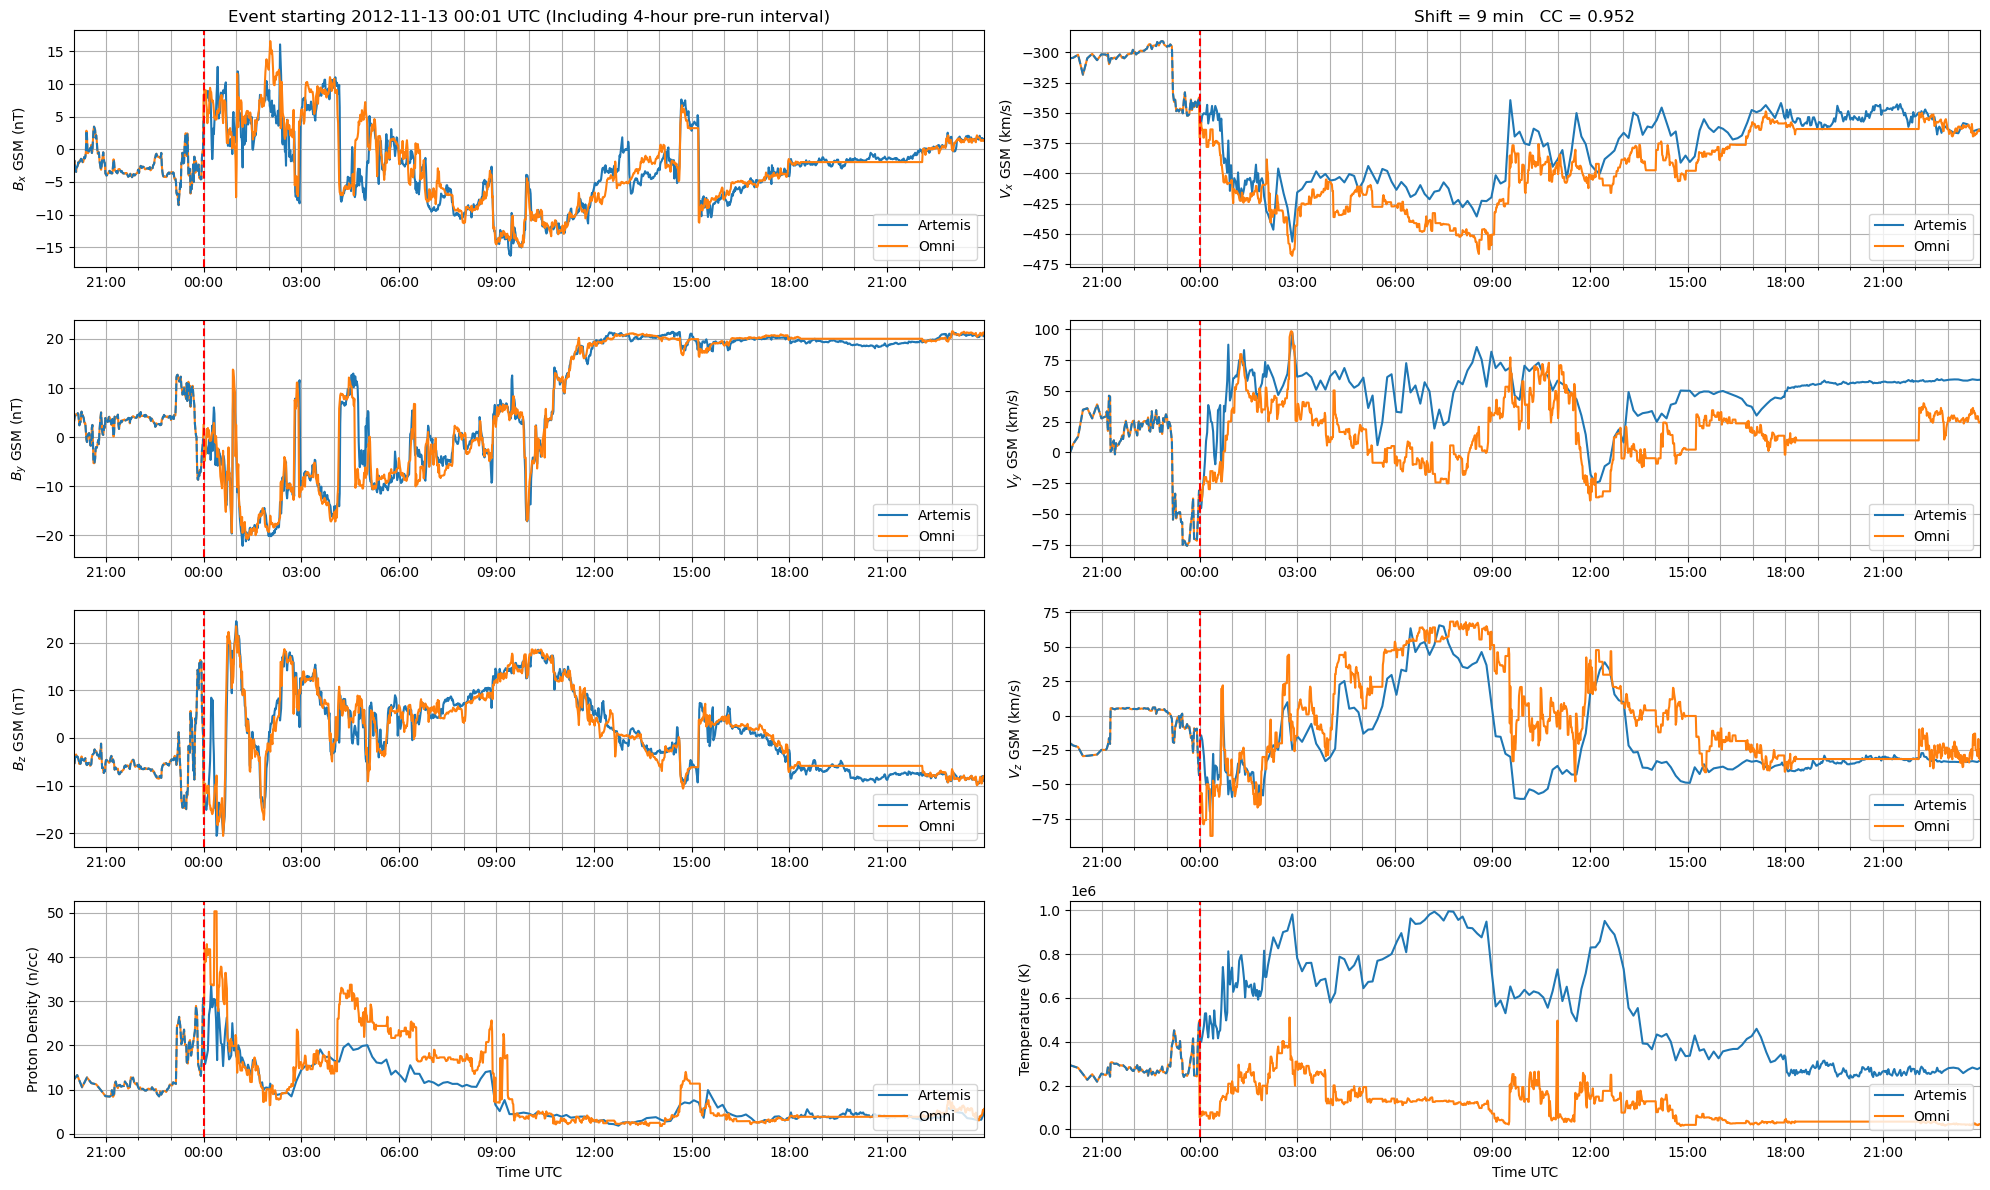

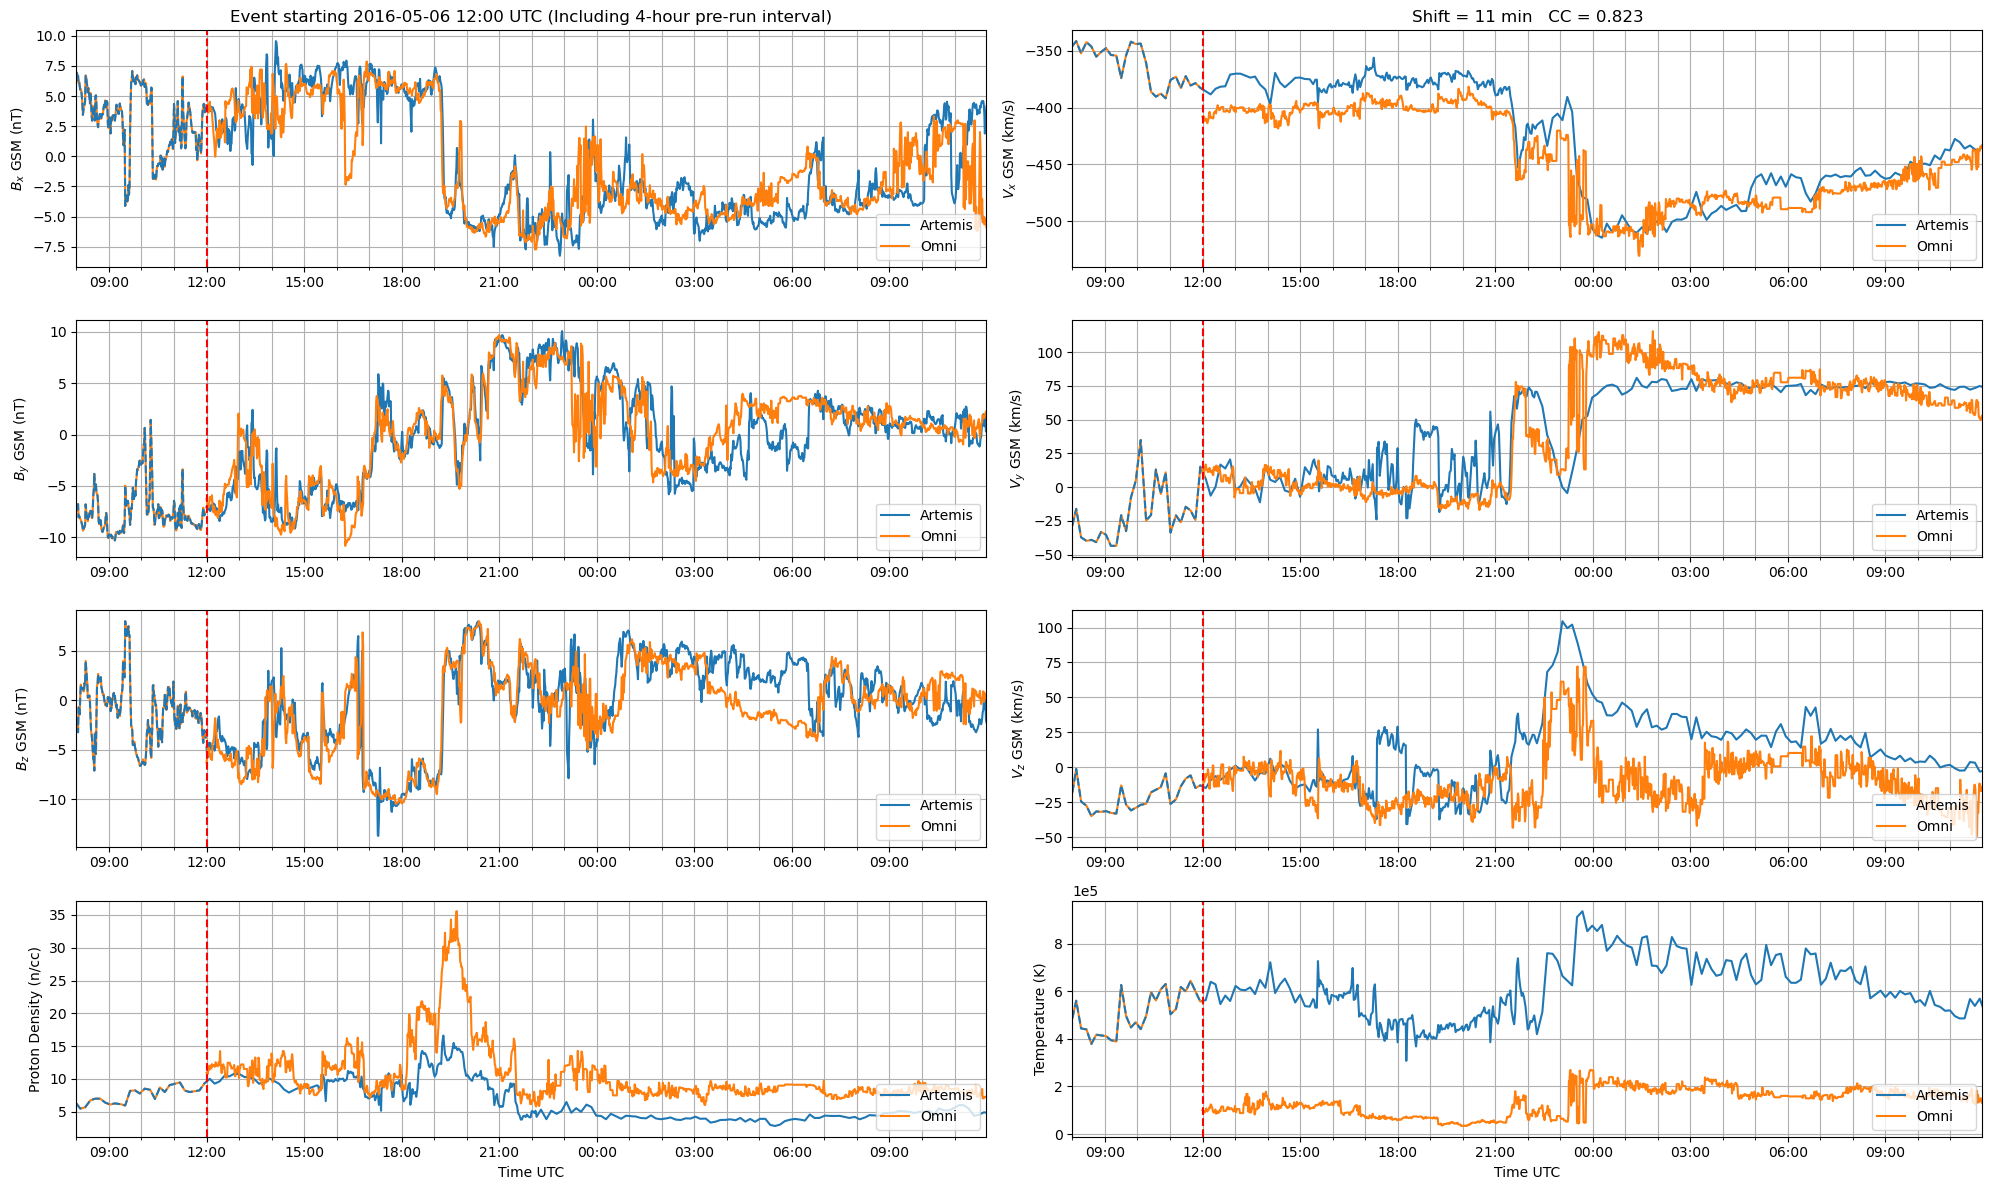

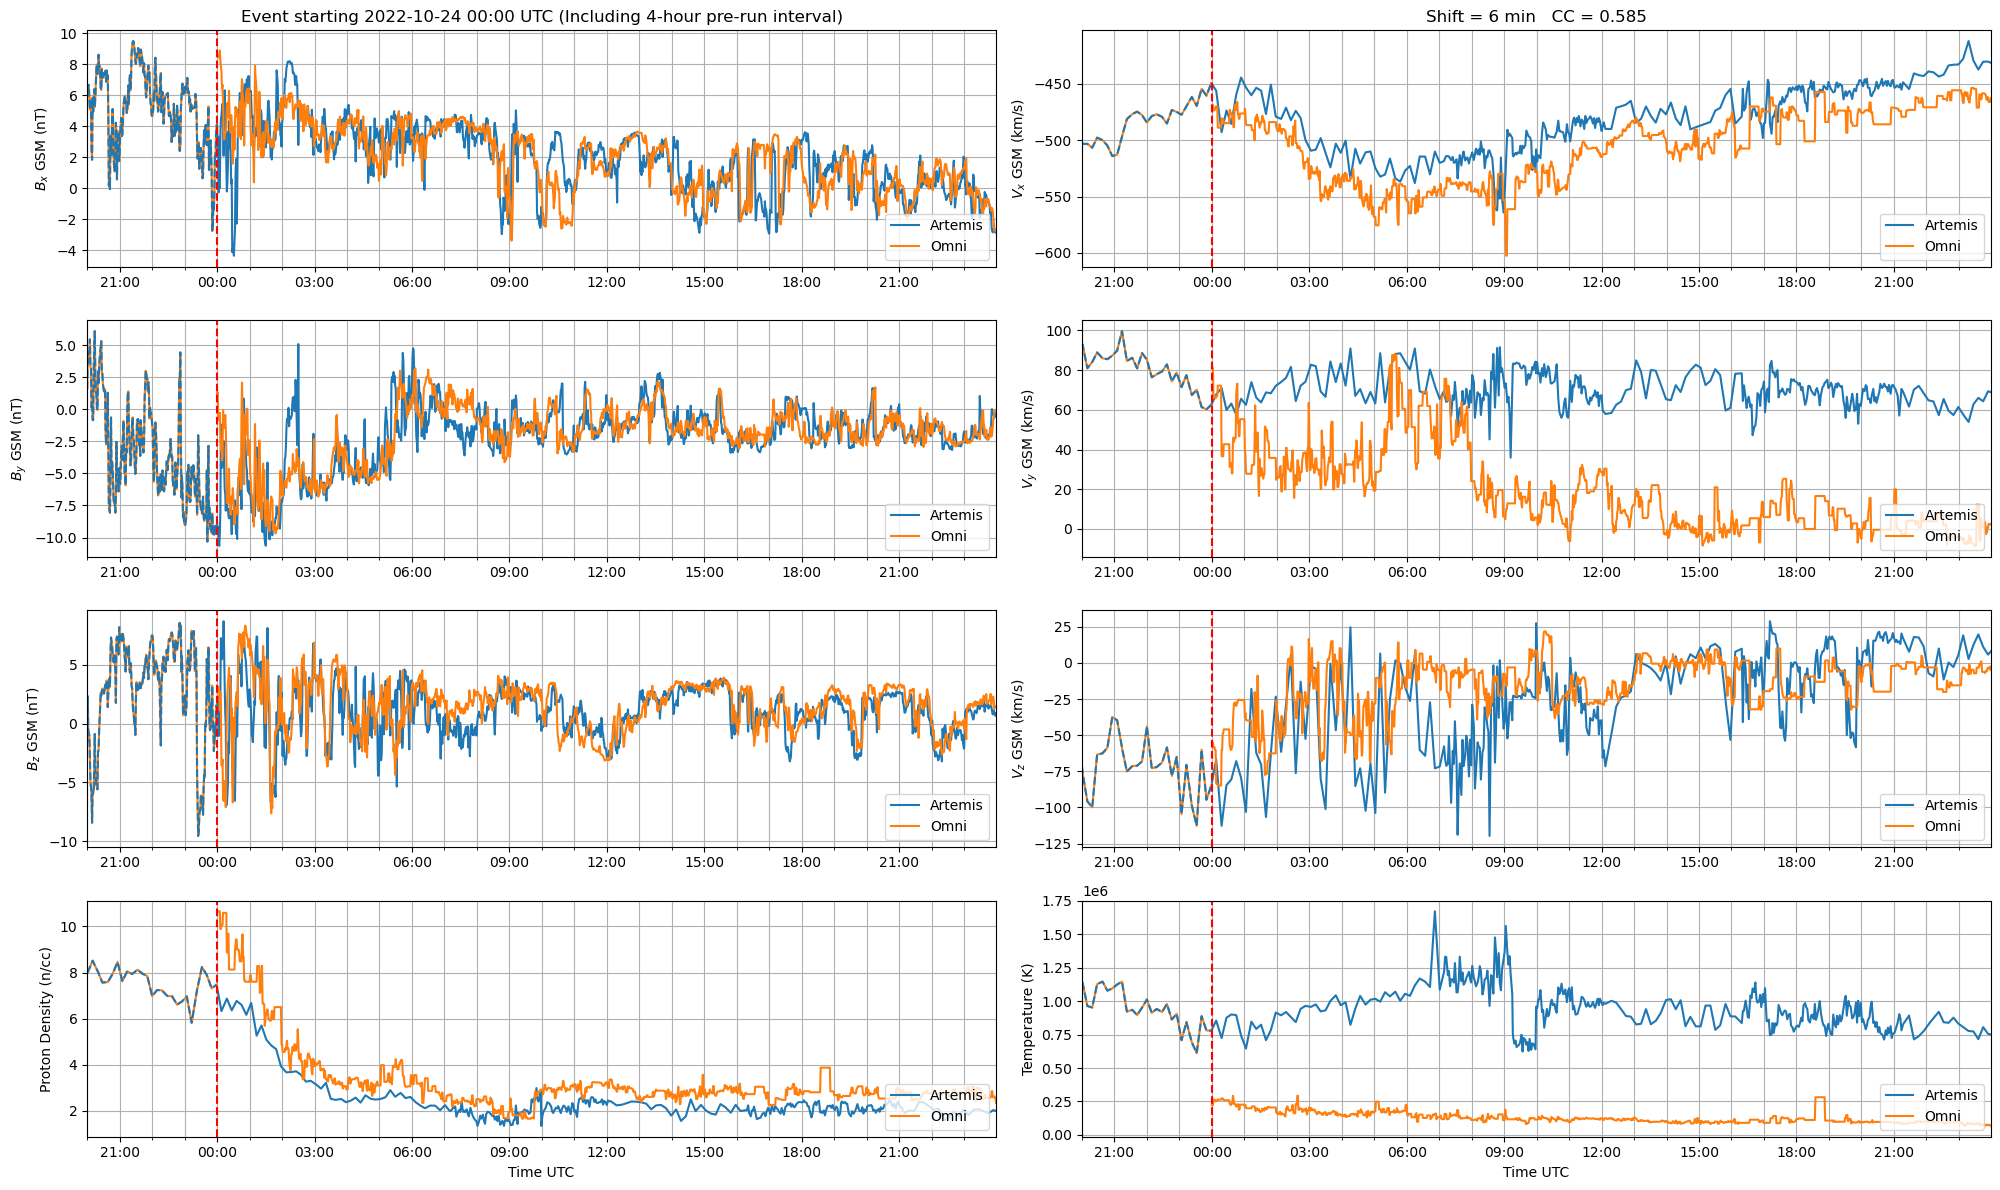

In [39]:
# Plots all three events with the 4-hour prerun interval. It makes this interval dashed.
keys = [6, 9, 7, 10, 8, 11, 12, 13]
names = [r'$B_x$ GSM (nT)', r'$V_x$ GSM (km/s)', r'$B_y$ GSM (nT)', r'$V_y$ GSM (km/s)', r'$B_z$ GSM (nT)', r'$V_z$ GSM (km/s)', r'Proton Density (n/cc)', 'Temperature (K)']

#keys = [6, 7, 8, 9, 10, 11, 12, 13]
#names = [r'$B_x$ GSM (nT)', r'$B_y$ GSM (nT)', r'$B_z$ GSM (nT)', r'$V_x$ GSM (km/s)', r'$V_y$ GSM (km/s)', r'$V_z$ GSM (km/s)', r'Proton Density (n/cc)', 'Temperature (K)']

keys2 = []
names2 = []
event_dates = ['2012-11-13', '2016-05-07', '2022-10-24']
file_dates = ['2012-11-12', '2016-05-06', '2022-10-23']

shifts = [9, 11, 6]
ccs = [0.952, 0.823, 0.585]

for s, d in enumerate(event_dates):
    artemis_data = pd.read_csv(f'simulation_inputs/{d}/Artemis_{file_dates[s]}.csv', delimiter=',', header=None)
    omni_data = pd.read_csv(f'simulation_inputs/{d}/Omni_{file_dates[s]}_sameprerun.csv', delimiter=',', header=None)

    for df in [artemis_data, omni_data]:
        datetime_columns = df.iloc[:, :6]
        df['timestamp'] = pd.to_datetime({
            'year': datetime_columns.iloc[:, 0],
            'month': datetime_columns.iloc[:, 1],
            'day': datetime_columns.iloc[:, 2],
            'hour': datetime_columns.iloc[:, 3],
            'minute': datetime_columns.iloc[:, 4],
            'second': datetime_columns.iloc[:, 5]})

    # Define the event start time
    event_start_time = omni_data['timestamp'].iloc[0] + dt.timedelta(hours=4)
    # Split data into segments based on the start time
    artemis_before = artemis_data[artemis_data['timestamp'] < event_start_time]
    artemis_after = artemis_data[artemis_data['timestamp'] >= event_start_time]
    omni_before = omni_data[omni_data['timestamp'] < event_start_time]
    omni_after = omni_data[omni_data['timestamp'] >= event_start_time]

    fig, ax = plt.subplots(4, 2, figsize=(2.5*len(keys), 12), sharex=True)
    ax = ax.flatten()
    for i, (k, n) in enumerate(zip(keys, names)):

        ax[i].plot(omni_before['timestamp'], omni_before[k], color='C1')    # Plot OMNI data before the dashed line
        ax[i].plot(artemis_before['timestamp'], artemis_before[k], color='C0', linestyle='dashed')  # Plot ARTEMIS data before the dashed line

        ax[i].plot(artemis_after['timestamp'], artemis_after[k], label='Artemis', color='C0')   # Plot ARTEMIS data after the dashed line
        ax[i].plot(omni_after['timestamp'], omni_after[k], label='Omni', color='C1')    # Plot OMNI data after the dashed line

        ax[i].set_ylabel(n)

        ax[i].grid(visible=True, which='both', axis='both')
        ax[i].axvline(x=event_start_time, c='red', linestyle='dashed')
        ax[i].tick_params(labelbottom=True)
        ax[i].legend(loc='lower right')

    first_timestamp = omni_data['timestamp'].iloc[0]
    first_hour = first_timestamp.hour
    first_major_tick_hour = (first_hour // 3) * 3  # Nearest hour divisible by 3

    major_ticks = pd.date_range(start=omni_data['timestamp'].iloc[0].replace(hour=first_major_tick_hour, minute=0, second=0), end=omni_data['timestamp'].iloc[-1], freq='3H')

    ax[-1].xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Major ticks every 3 hours
    ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 12-hour format with AM/PM
    ax[-1].xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Minor ticks every hour

    ax[-1].set_xticks(major_ticks)

    ax[-1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[6].set_xlabel('Time UTC')
    ax[7].set_xlabel('Time UTC')


    ax[-1].set_xlim([omni_data['timestamp'].iloc[0], omni_data['timestamp'].iloc[-1]])

    ax[0].set_title(f'Event starting {(event_start_time).strftime("%Y-%m-%d %H:%M")} UTC (Including 4-hour pre-run interval)')
    ax[1].set_title(f'Shift = {round(shifts[s], 3)} min   CC = {round(ccs[s], 3)}')
    #ax[1].text(0.8, 1.05, f'Shift = {round(shifts[s], 3)} min', transform=ax[0].transAxes, ha='left')
    #ax[1].text(0.92, 1.05, f'CC = {round(ccs[s], 3)}', transform=ax[0].transAxes, ha='left')

    plt.tight_layout()
    bbox_inches="tight"
    plt.savefig(f'simulation_inputs/{(event_start_time).strftime("%Y-%m-%d")}-rectangle.png', dpi=300)

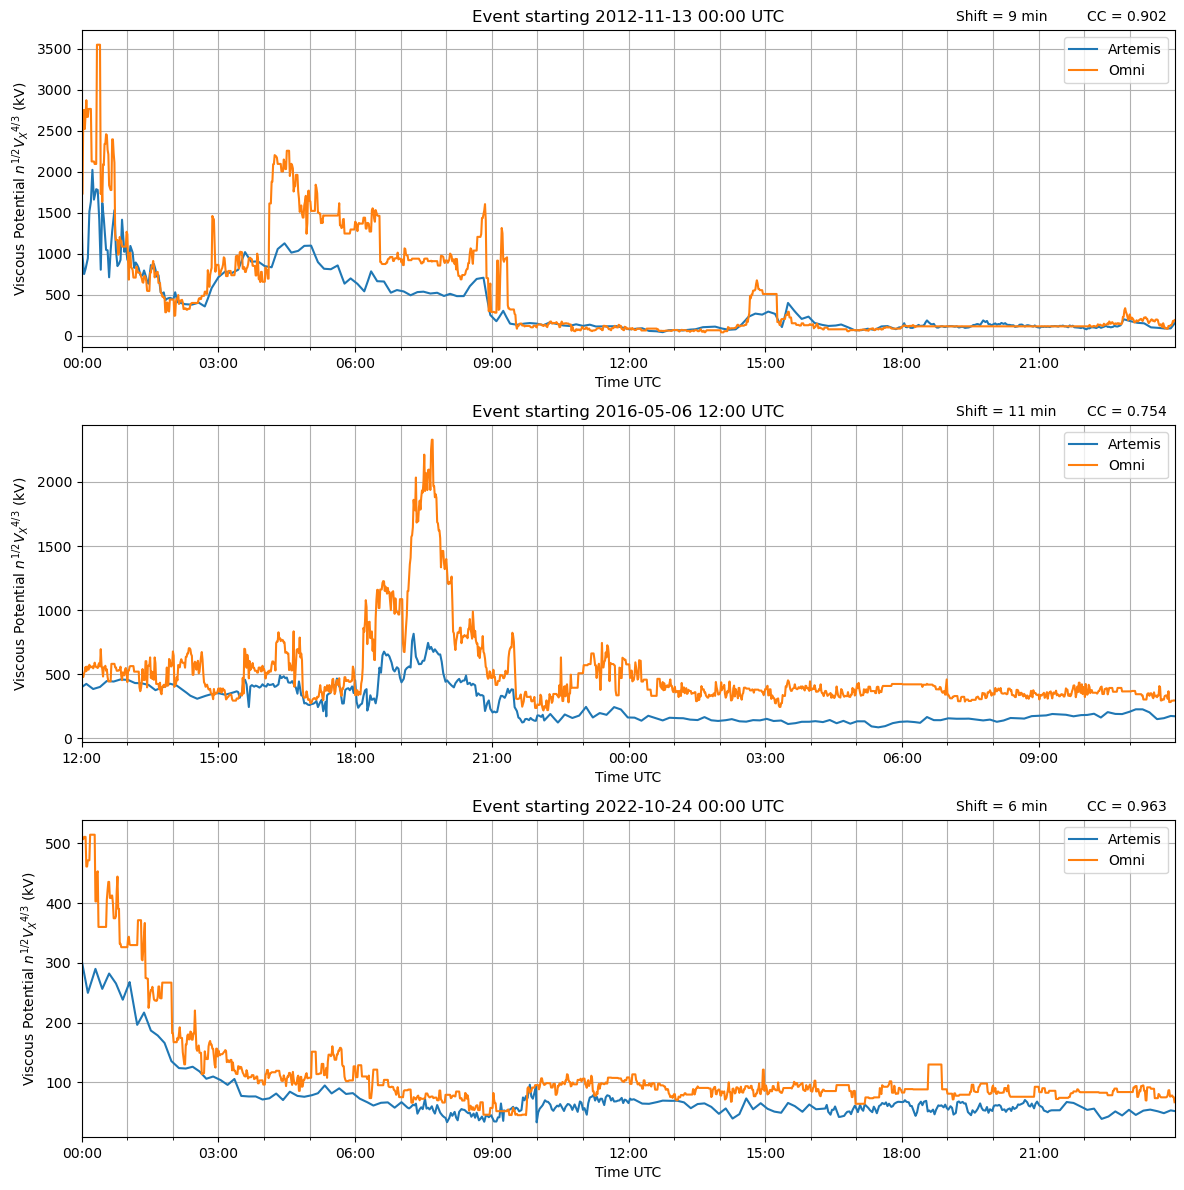

In [33]:
keys = [9, 10, 11, 12]
names = [r'$V_x$ GSM (km/s)', r'$V_y$ GSM (km/s)', r'$V_z$ GSM (km/s)', r'Proton Density (n/cc)']

event_dates = ['2012-11-13', '2016-05-07', '2022-10-24']
file_dates = ['2012-11-12', '2016-05-06', '2022-10-23']

shifts = [9, 11, 6]
ccs = [0.952, 0.823, 0.585]

fig, ax = plt.subplots(3, 1, figsize=(12, 12)) # Set up the three subplots

for s, d in enumerate(event_dates):
    artemis_data = pd.read_csv(f'simulation_inputs/{d}/Artemis_{file_dates[s]}.csv', delimiter=',', header=None)
    omni_data = pd.read_csv(f'simulation_inputs/{d}/Omni_{file_dates[s]}_sameprerun.csv', delimiter=',', header=None)

    for df in [artemis_data, omni_data]:
        datetime_columns = df.iloc[:, :6]
        df['timestamp'] = pd.to_datetime({
            'year': datetime_columns.iloc[:, 0],
            'month': datetime_columns.iloc[:, 1],
            'day': datetime_columns.iloc[:, 2],
            'hour': datetime_columns.iloc[:, 3],
            'minute': datetime_columns.iloc[:, 4],
            'second': datetime_columns.iloc[:, 5]})

    # Define the event start time
    if d == '2012-11-13':
        event_start_time = omni_data['timestamp'].iloc[0] + dt.timedelta(hours=4) - dt.timedelta(minutes=1)
    else:
        event_start_time = omni_data['timestamp'].iloc[0] + dt.timedelta(hours=4)
    artemis_after = artemis_data[artemis_data['timestamp'] >= event_start_time]
    omni_after = omni_data[omni_data['timestamp'] >= event_start_time]

    artemis_vp = ((abs(artemis_after[9])**(1/2))*(artemis_after[12]**(4/3)))
    omni_vp = ((abs(omni_after[9])**(1/2))*(omni_after[12]**(4/3)))
    correlation, _ = pearsonr(omni_vp, artemis_vp)

    ax[s].plot(artemis_after['timestamp'], artemis_vp, label='Artemis', color='C0')   # Plot ARTEMIS data after the dashed line
    ax[s].plot(omni_after['timestamp'], omni_vp, label='Omni', color='C1')    # Plot OMNI data after the dashed line

    ax[s].grid(visible=True, which='both', axis='both')
    ax[s].tick_params(labelbottom=True)
    ax[s].legend(loc='upper right')

    first_timestamp = omni_after['timestamp'].iloc[0]
    first_hour = first_timestamp.hour
    first_major_tick_hour = (first_hour // 3) * 3  # Nearest hour divisible by 3

    major_ticks = pd.date_range(start=omni_after['timestamp'].iloc[0].replace(hour=first_major_tick_hour, minute=0, second=0), end=omni_after['timestamp'].iloc[-1], freq='3H')
    ax[s].xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Major ticks every 3 hours
    ax[s].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 12-hour format with AM/PM
    ax[s].xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Minor ticks every hour
    ax[s].set_xticks(major_ticks)

    ax[s].set(xlabel = f'Time UTC', ylabel = r'Viscous Potential $n^{1/2} {V_X}^{4/3}$ (kV)', xlim = [omni_after['timestamp'].iloc[0], omni_after['timestamp'].iloc[-1]], title = f'Event starting {(event_start_time).strftime("%Y-%m-%d %H:%M")} UTC')

    ax[s].text(0.8, 1.03, f'Shift = {round(shifts[s], 3)} min', transform=ax[s].transAxes, ha='left')
    ax[s].text(0.92, 1.03, f'CC = {round(correlation, 3)}', transform=ax[s].transAxes, ha='left')

plt.tight_layout()
plt.savefig(f'empirical_CPCP.png', dpi=300)

2012-11-13
Average Bz ARTEMIS: 1.6065032131924943
Average Bz OMNI: 1.686483669214732
Artemis: 797 minutes positive; 642 minutes negative
OMNI: 815 minutes positive; 624 minutes negative

2012-11-13
Velocity correlation : 0.9315717352832245
Density correlation : 0.9227418872905324

2016-05-06
Average Bz ARTEMIS: -0.26318310068611117
Average Bz OMNI: -0.7878888888888889
Artemis: 773 minutes positive; 667 minutes negative
OMNI: 695 minutes positive; 743 minutes negative

2016-05-06
Velocity correlation : 0.9592676207506152
Density correlation : 0.7705692067423267

2022-10-24
Average Bz ARTEMIS: 1.0611557343264584
Average Bz OMNI: 1.4602291666666667
Artemis: 1028 minutes positive; 412 minutes negative
OMNI: 1098 minutes positive; 338 minutes negative

2022-10-24
Velocity correlation : 0.897846946099906
Density correlation : 0.9578538637200775



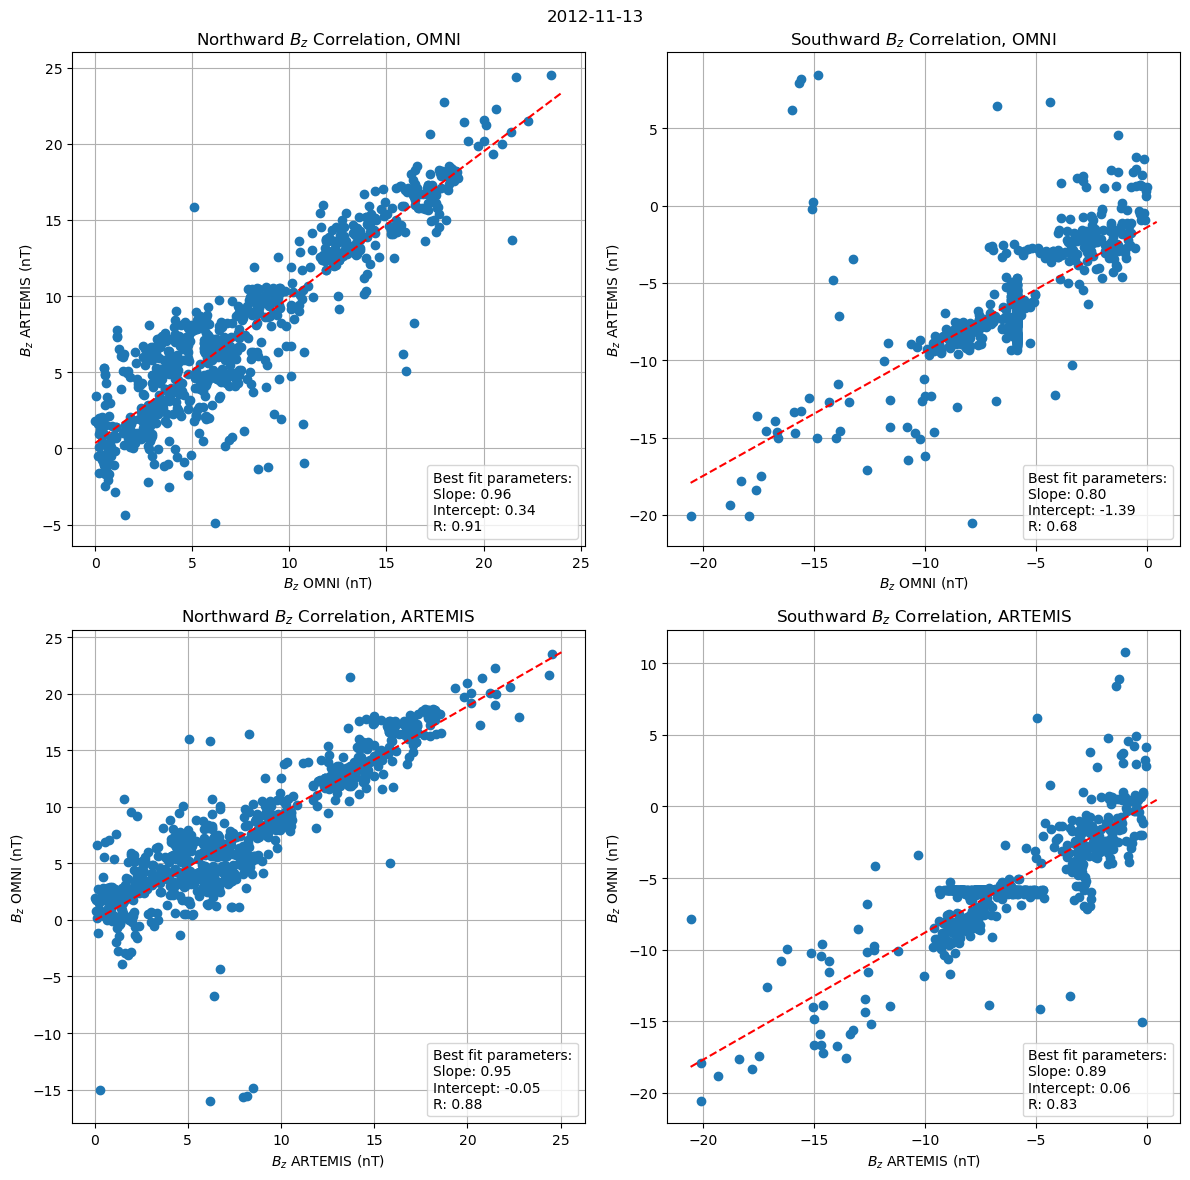

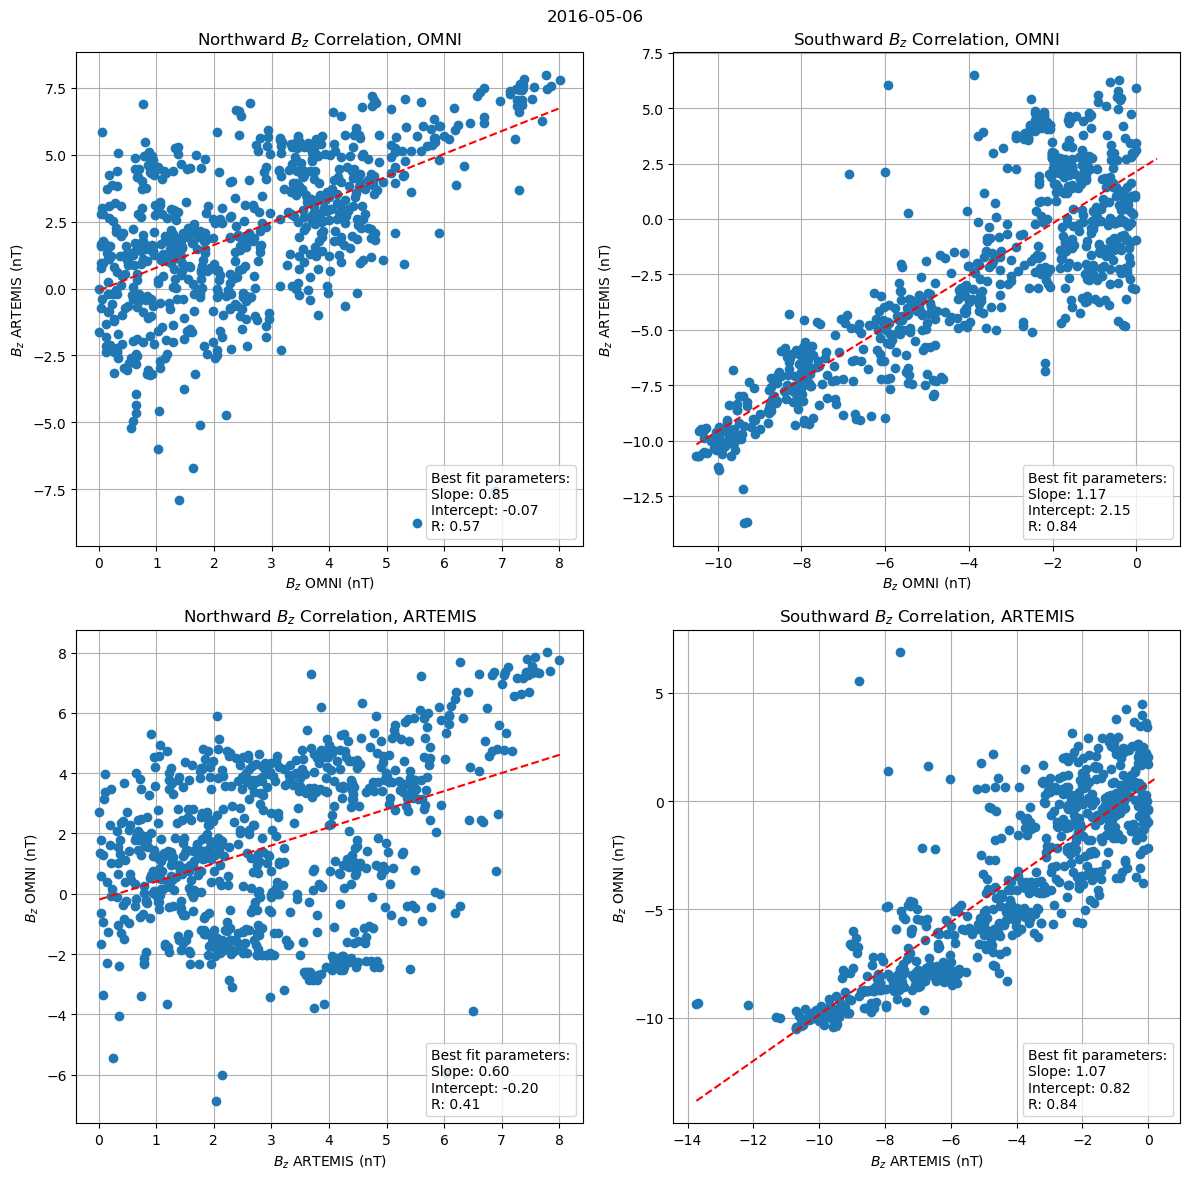

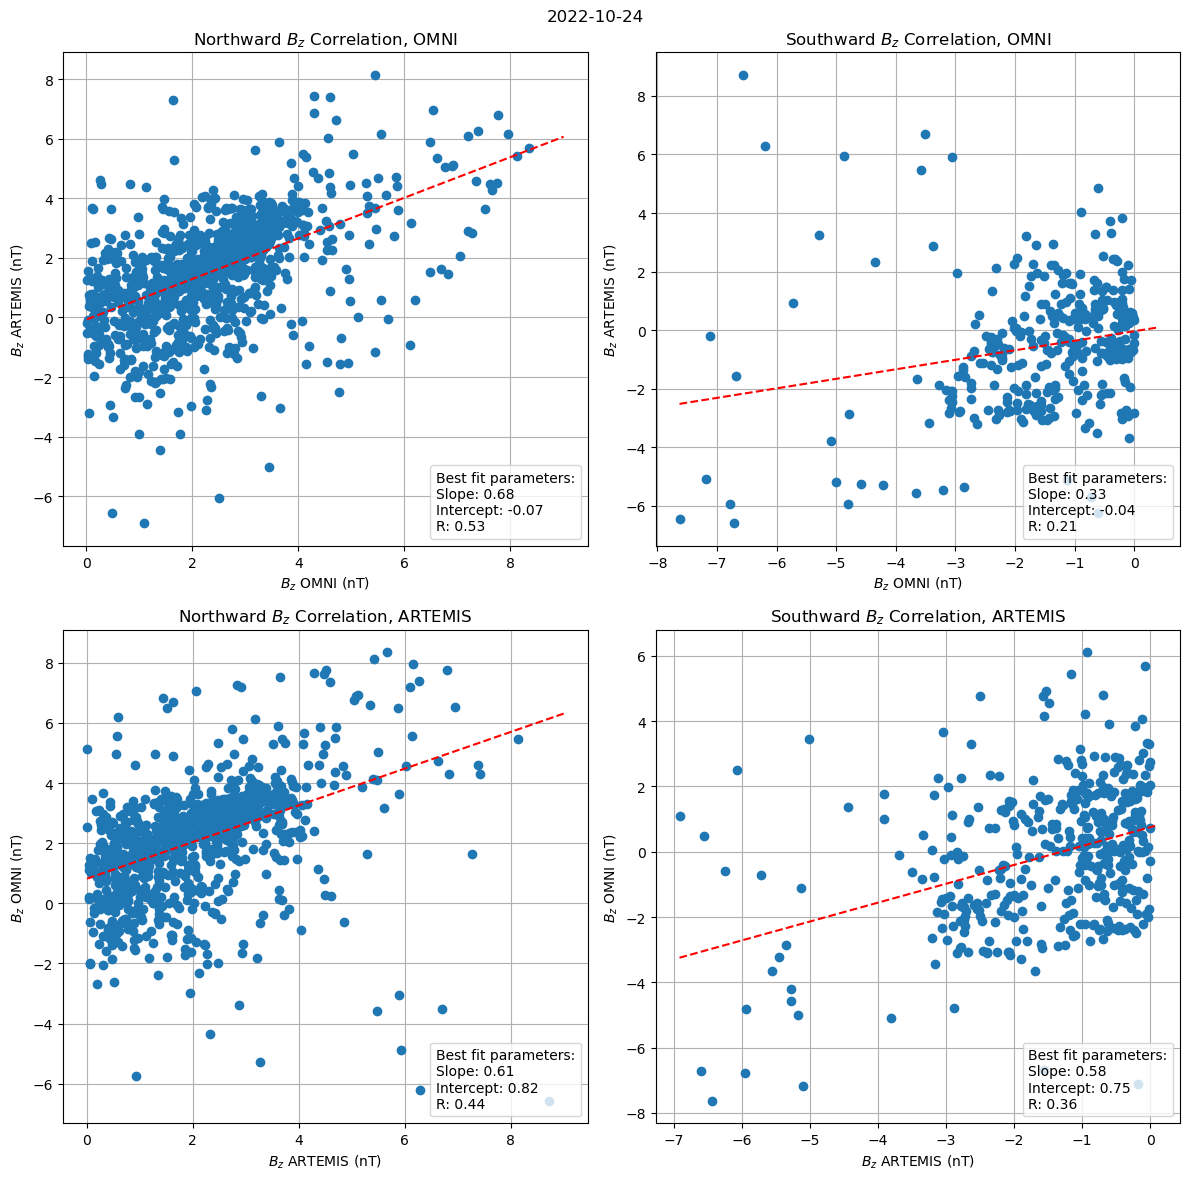

In [31]:
# Plots all three events with the 4-hour prerun interval. It makes this interval dashed.
keys = [6, 7, 8, 9, 10, 11, 12, 13]
names = [r'$B_x$ GSM (nT)', r'$B_y$ GSM (nT)', r'$B_z$ GSM (nT)', r'$V_x$ GSM (km/s)', r'$V_y$ GSM (km/s)', r'$V_z$ GSM (km/s)', r'Proton Density (n/cc)', 'Temperature (K)']

event_dates = ['2012-11-13', '2016-05-07', '2022-10-24']
file_dates = ['2012-11-12', '2016-05-06', '2022-10-23']

shifts = [9, 11, 6]
ccs = [0.952, 0.823, 0.585]

for s, d in enumerate(event_dates):
    artemis_data = pd.read_csv(f'simulation_inputs/{d}/Artemis_{file_dates[s]}.csv', delimiter=',', header=None)
    omni_data = pd.read_csv(f'simulation_inputs/{d}/Omni_{file_dates[s]}_sameprerun.csv', delimiter=',', header=None)

    for df in [artemis_data, omni_data]:
        datetime_columns = df.iloc[:, :6]
        df['timestamp'] = pd.to_datetime({
            'year': datetime_columns.iloc[:, 0],
            'month': datetime_columns.iloc[:, 1],
            'day': datetime_columns.iloc[:, 2],
            'hour': datetime_columns.iloc[:, 3],
            'minute': datetime_columns.iloc[:, 4],
            'second': datetime_columns.iloc[:, 5]})

    # Define the event start time
    event_start_time = omni_data['timestamp'].iloc[0] + dt.timedelta(hours=4)

    for i, (k, n) in enumerate(zip(keys, names)):
        artemis_after = artemis_data[artemis_data['timestamp'] >= event_start_time]
        omni_after = omni_data[omni_data['timestamp'] >= event_start_time]

    print(f'{(event_start_time).strftime("%Y-%m-%d")}\n'
          f'Average Bz ARTEMIS: {np.average(artemis_after[8])}\n'
          f'Average Bz OMNI: {np.average(omni_after[8])}\n'
          f'Artemis: {len([i for i in artemis_after[8] if i>0])} minutes positive; {len([i for i in artemis_after[8] if i<0])} minutes negative\n'
          f'OMNI: {len([i for i in omni_after[8] if i>0])} minutes positive; {len([i for i in omni_after[8] if i<0])} minutes negative\n')

    vx_correlation, _ = pearsonr(omni_after[9], artemis_after[9])
    n_correlation, _ = pearsonr(omni_after[12], artemis_after[12])

    print(f'{(event_start_time).strftime("%Y-%m-%d")}\n'
          f'Velocity correlation: {vx_correlation}\n'
          f'Density correlation: {n_correlation}\n')

    fig, ax = plt.subplots(2, 2, figsize=(12,12))

    ax[0,0].set(title=r'Northward $B_z$ Correlation, OMNI', xlabel=r'$B_z$ OMNI (nT)', ylabel=r'$B_z$ ARTEMIS (nT)')
    ax[0,1].set(title=r'Southward $B_z$ Correlation, OMNI', xlabel=r'$B_z$ OMNI (nT)', ylabel=r'$B_z$ ARTEMIS (nT)')
    ax[1,0].set(title=r'Northward $B_z$ Correlation, ARTEMIS', xlabel=r'$B_z$ ARTEMIS (nT)',  ylabel=r'$B_z$ OMNI (nT)')
    ax[1,1].set(title=r'Southward $B_z$ Correlation, ARTEMIS', xlabel=r'$B_z$ ARTEMIS (nT)', ylabel=r'$B_z$ OMNI (nT)')

    mask_pos_omni = omni_after[8] > 0
    mask_neg_omni = omni_after[8] < 0
    mask_pos_artemis = artemis_after[8] > 0
    mask_neg_artemis = artemis_after[8] < 0


    def plot_scatter(x, y, axis):
        s, i, r, p, std_err = linregress(x, y)
        x_linear = np.arange(min(x), max(x)+1, 1)
        line = s*x_linear + i

        axis.set_axisbelow(True)    # Puts the grid in the background
        axis.grid(visible=True, which='both', axis='both')
        axis.scatter(x, y)
        axis.plot(x_linear, line, color='red', linestyle='dashed', label=f'Best fit parameters:\nSlope: {s:.2f}\nIntercept: {i:.2f}\nR: {r:.2f}')
        axis.legend(handlelength=0, handletextpad=0, loc='lower right')


    plot_scatter(omni_after[8][mask_pos_omni], artemis_after[8][mask_pos_omni], ax[0,0])
    plot_scatter(omni_after[8][mask_neg_omni], artemis_after[8][mask_neg_omni], ax[0,1])
    plot_scatter(artemis_after[8][mask_pos_artemis], omni_after[8][mask_pos_artemis], ax[1,0])
    plot_scatter(artemis_after[8][mask_neg_artemis], omni_after[8][mask_neg_artemis], ax[1,1])

    plt.suptitle(f'{(event_start_time).strftime("%Y-%m-%d")}')
    plt.tight_layout()
    plt.savefig(f'plots/correlations n-s/{(event_start_time).strftime("%Y-%m-%d")}.jpg', dpi=300)